In [2]:
import pandas as pa
import numpy
import matplotlib.pyplot as plt
import re
import ast
import folium
from folium.plugins import HeatMap
from IPython.display import display  # Import display from IPython to show the map in Jupyter
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np


# Analysis focuses on 97% of the market ($0–$2M) to highlight trends for majority buyers/owners. 
# Luxury properties with possible outlier data (>$2M) are analyzed separately due to differing demand drivers."

# frame setting
pa.set_option('display.max_columns', None)

# ------------------------------------------------------------------------------main
f = pa.read_csv("C:/Users/acer/Jupyter/TradeMe/data.csv")
f = f.drop_duplicates(subset=['ListingId'])
f = f.drop(columns=['PhotoUrls', 'Amenities', 'IsNew', 'ViewingInstructions', 'ListingExtras', 'BestContactTime','Category', 'PropertyId', 'StartPrice', 'Has3DTour', 'IsFeatured', 'PremiumPackageCode', 'IsSuperFeatured', 'VariantDefinitionSummary', 'IsHighlighted', 'IsBold','StartDate', 'EndDate', 'ListingLength', 'HasGallery', 'PictureHref', 'NoteDate', 'ReserveState', 'IsClassified', 'OpenHomes', 'HasEmbeddedVideo', 'AdditionalData', 'MemberId'])

print(f.info())

# ----------------------------------------------------------------------------Extract Property Asking Price from PriceDisplay Column
def extract_price(price_text):
    # Use regular expression to extract numeric part (digits and commas)
    match = re.search(r'[\d,]+', str(price_text))
    if match:
        # Remove commas and convert to float
        return float(match.group().replace(',', ''))
    return None

f['PriceDisplay'] = f['PriceDisplay'].apply(extract_price)
f = f.dropna(subset=['PriceDisplay'])
print(f.info())

# ----------------------------------------------------------------------------Extract coordinates for heatmap
def extract_lat_long(geo_location):
    try:
        # Safely evaluate the string as a dictionary
        geo_dict = ast.literal_eval(geo_location)
        latitude = geo_dict.get('Latitude', None)
        longitude = geo_dict.get('Longitude', None)
        return latitude, longitude
    except:
        return None, None

f['Latitude'], f['Longitude'] = zip(*f['GeographicLocation'].apply(extract_lat_long))
f.info()
# Remove rows where Latitude or Longitude is missing
f = f.dropna(subset=['Latitude', 'Longitude'])

pa.set_option('display.float_format', '{:,.2f}'.format) 
f.describe()



<class 'pandas.core.frame.DataFrame'>
Index: 31762 entries, 0 to 31999
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ListingId            31762 non-null  int64  
 1   Title                31762 non-null  object 
 2   AsAt                 31762 non-null  object 
 3   CategoryPath         31762 non-null  object 
 4   RegionId             31762 non-null  int64  
 5   Region               31762 non-null  object 
 6   SuburbId             31762 non-null  int64  
 7   Suburb               31762 non-null  object 
 8   GeographicLocation   31762 non-null  object 
 9   PriceDisplay         31762 non-null  object 
 10  Address              31161 non-null  object 
 11  District             31762 non-null  object 
 12  AgencyReference      27844 non-null  object 
 13  LandArea             24305 non-null  float64
 14  ListingGroup         31762 non-null  object 
 15  Parking              19836 non-null  obje

,ListingId,RegionId,SuburbId,PriceDisplay,LandArea,RateableValue,DistrictId,Bathrooms,Bedrooms,TotalParking,Area,Lounges,Latitude,Longitude
count,"18,367.00","18,367.00","18,367.00","18,367.00","14,474.00","7,392.00","18,367.00","14,909.00","14,905.00","11,315.00","11,451.00","6,290.00","18,367.00","18,367.00"
mean,"4,071,028,835.09",7.12,"1,569.26","820,872.10","60,549.25","736,658.62",33.15,1.66,3.10,2.35,153.84,1.32,-39.77,173.99
std,"203,477,238.99",5.15,"1,010.21","590,869.82","6,003,247.22","4,035,699.46",24.22,0.72,0.98,1.58,82.09,0.56,3.35,3.05
min,"1,166,228,136.00",1.00,2.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,-46.90,-6.26
25%,"4,000,345,083.00",2.00,625.00,"485,000.00",506.00,"393,000.00",10.00,1.00,3.00,1.00,100.00,1.00,-42.46,172.69
50%,"4,137,450,793.00",6.00,"1,571.00","700,000.00",752.00,"590,000.00",31.00,2.00,3.00,2.00,140.00,1.00,-39.00,174.73
75%,"4,210,564,792.50",12.00,"2,305.00","975,000.00","1,710.00","850,000.00",58.00,2.00,4.00,3.00,190.00,2.00,-37.04,175.32
max,"4,267,607,907.00",16.00,"3,790.00","15,000,000.00","721,830,000.00","345,000,000.00",83.00,6.00,6.00,12.00,"2,292.00",6.00,53.35,178.29


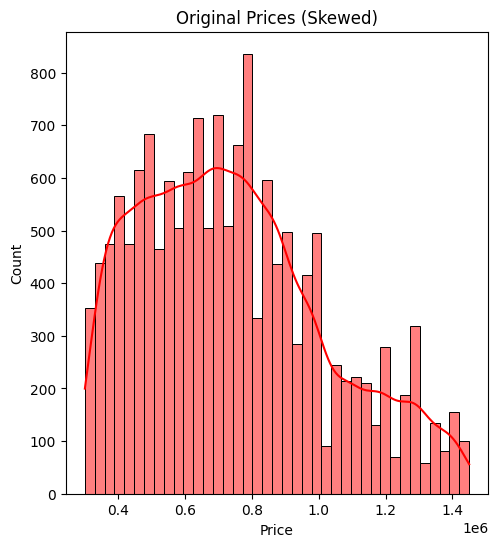

,ListingId,RegionId,SuburbId,PriceDisplay,LandArea,RateableValue,DistrictId,Bathrooms,Bedrooms,TotalParking,Area,Lounges,Latitude,Longitude,norm_price
count,"15,283.00","15,283.00","15,283.00","15,283.00","12,099.00","6,284.00","15,283.00","12,855.00","12,852.00","9,928.00","9,903.00","5,488.00","15,283.00","15,283.00","15,283.00"
mean,"4,079,095,175.31",7.15,"1,600.78","741,837.17","66,761.15","699,381.09",33.44,1.59,3.04,2.25,145.78,1.26,-39.83,174.05,0.28
std,"192,548,542.90",5.11,991.69,"275,261.08","6,563,127.11","4,355,261.69",23.99,0.62,0.91,1.48,64.75,0.47,3.12,1.97,0.14
min,"1,166,228,136.00",1.00,2.00,"300,000.00",1.00,195.00,1.00,1.00,0.00,1.00,1.00,1.00,-46.90,164.15,0.06
25%,"4,009,305,907.00",2.00,696.00,"525,000.00",496.00,"425,000.00",10.00,1.00,3.00,1.00,100.00,1.00,-42.80,172.67,0.17
50%,"4,144,574,070.00",6.00,"1,624.00","700,000.00",713.00,"590,000.00",32.00,2.00,3.00,2.00,140.00,1.00,-39.06,174.72,0.26
75%,"4,212,069,705.50",12.00,"2,305.00","900,000.00","1,254.50","800,000.00",59.00,2.00,4.00,3.00,180.00,1.00,-37.14,175.33,0.36
max,"4,267,607,907.00",16.00,"3,786.00","1,450,000.00","721,830,000.00","345,000,000.00",83.00,6.00,6.00,12.00,"1,735.00",6.00,-34.77,178.29,0.64


In [15]:
lower_percentile = f['PriceDisplay'].quantile(0.01)  # 1st percentile
upper_percentile = f['PriceDisplay'].quantile(0.99)  # 99th percentile
f = f[(f['PriceDisplay'] >= lower_percentile) & (f['PriceDisplay'] <= upper_percentile)]

lower_percentile = f['PriceDisplay'].quantile(0.05)  # 1st percentile
upper_percentile = f['PriceDisplay'].quantile(0.95)  # 99th percentile
f = f[(f['PriceDisplay'] >= lower_percentile) & (f['PriceDisplay'] <= upper_percentile)]

plt.figure(figsize=(12, 6))
# Original Prices (Heavy Right Tail)
plt.subplot(1, 2, 1)
sns.histplot(f['PriceDisplay'], kde=True, color='red')
plt.title('Original Prices (Skewed)')
plt.xlabel('Price')
plt.show()
f.describe()

In [17]:

# - remove coordinates outliers outside New Zealand 
f = f[ 
(f["Latitude"].between(-50, -30)) & 
    (f["Longitude"].between(160, 180))
]
# - IQR remove

# - Normalized log price to 0 -1 
f["norm_price"] = (f["PriceDisplay"] - f["PriceDisplay"].min()) / (f["PriceDisplay"].max() - f["PriceDisplay"].min())

# Create a base map centered on an average location of the properties
map_center = [f['Latitude'].mean(), f['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)
heat_data = [[row['Latitude'], row['Longitude'], row['norm_price']] for index, row in f.iterrows()]

HeatMap(
    heat_data,
    radius=5,  
    blur=4,   
    max_zoom=15,
).add_to(m)

display(m)  # This will display the map directly in the notebook

print("Price heatmap has been displayed in the notebook.")
f["norm_price"].describe()

Price heatmap has been displayed in the notebook.


count   15,283.00
mean         0.38
std          0.24
min          0.00
25%          0.20
50%          0.35
75%          0.52
max          1.00
Name: norm_price, dtype: float64

In [1]:
# --------------------------------------------------------------------------- 
# Step 1: Calculate 5th and 95th Percentiles for PriceDisplay
lower_percentile = f['PriceDisplay'].quantile(0.05)  # 5th percentile
upper_percentile = f['PriceDisplay'].quantile(0.95)  # 95th percentile

print(f"5th percentile (lower): ${lower_percentile:,.0f}")
print(f"95th percentile (upper): ${upper_percentile:,.0f}")

# --------------------------------------------------------------------------- 
# Step 2: Cap/Clip values between these percentiles
f['PriceDisplay_capped'] = np.clip(
    f['PriceDisplay'],
    lower_percentile,
    upper_percentile
)

# --------------------------------------------------------------------------- 
# Step 3: Compare distribution before/after
plt.figure(figsize=(12, 6))

# Original Prices (Heavy Right Tail)
plt.subplot(1, 2, 1)
sns.histplot(f['PriceDisplay'], kde=True, color='red')
plt.title('Original Prices (Skewed)')
plt.xlabel('Price')

# Capped Prices (5%-95% Range)
plt.subplot(1, 2, 2)
sns.histplot(f['PriceDisplay_capped'], kde=True, color='green')
plt.title('Capped Prices (5th-95th Percentiles)')
plt.xlabel('Price')

plt.tight_layout()
plt.show()


NameError: name 'f' is not defined

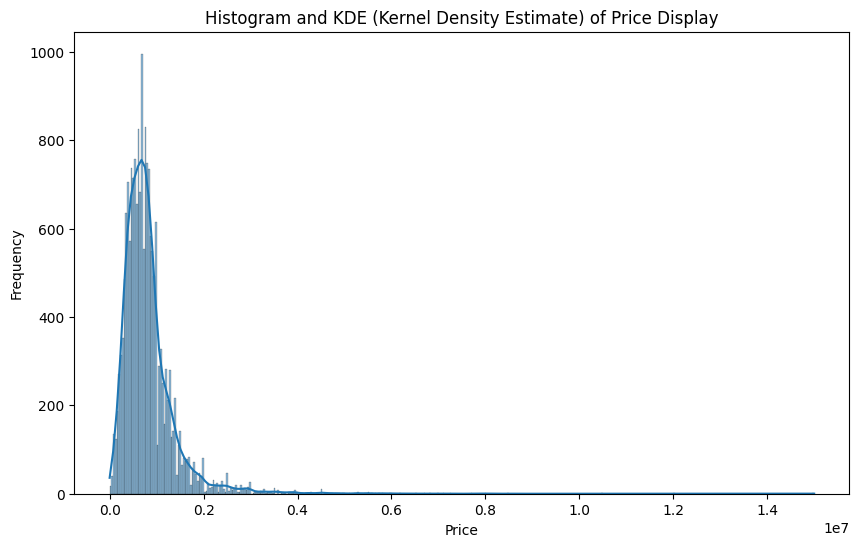

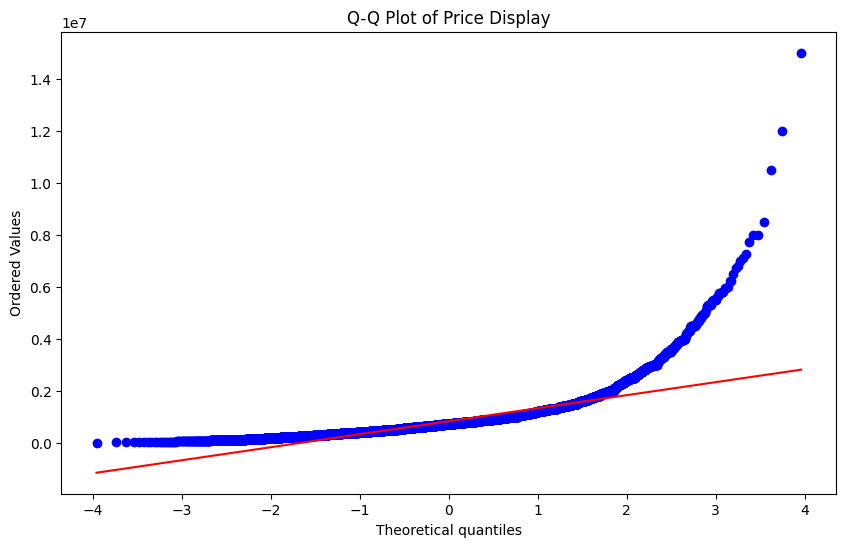

In [17]:
# Plotting a histogram
plt.figure(figsize=(10, 6))
sns.histplot(f['PriceDisplay'], kde=True)
plt.title('Histogram and KDE (Kernel Density Estimate) of Price Display')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(f['PriceDisplay'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot of Price Display')
plt.show()

In [24]:
property_over_2M = f[f['PriceDisplay']>2000000].shape[0]
property_over_2M

587

In [14]:
f['PriceDisplay'].describe()

count       18,364.00
mean       820,942.05
std        590,892.46
min              1.00
25%        485,000.00
50%        700,000.00
75%        975,000.00
max     15,000,000.00
Name: PriceDisplay, dtype: float64

In [12]:
f['PriceDisplay_log'] = np.log(f['PriceDisplay'] + 1)  
f['PriceDisplay_log'].describe()


count   18,364.00
mean        13.43
std          0.63
min          0.69
25%         13.09
50%         13.46
75%         13.79
max         16.52
Name: PriceDisplay_log, dtype: float64

In [4]:
# Log Transformation to counter right skewed "luxury property" or "OUTLIERS'
f['PriceDisplay_log'] = np.log(f['PriceDisplay'] + 1)  

suburb_stats = f.groupby('Suburb')[['PriceDisplay', 'PriceDisplay_log']].describe()
for stat in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
    suburb_stats[('PriceDisplay_log', f'converted_{stat}')] = np.exp(suburb_stats[('PriceDisplay_log', stat)]) - 1

# Show final output with converted values
suburb_stats

PriceDisplay                                              \
                       count       mean        std        min        25%   
Suburb                                                                     
Abbotsford              7.00 470,285.71 246,602.73 235,000.00 302,000.00   
Acacia Bay             14.00 830,357.14 564,760.21 149,000.00 471,500.00   
Addington              17.00 606,617.65 133,910.60 359,000.00 539,000.00   
Ahaura                  1.00 150,000.00        NaN 150,000.00 150,000.00   
Ahipara                15.00 524,466.67 254,274.00 239,000.00 290,000.00   
...                      ...        ...        ...        ...        ...   
Woodville              18.00 418,944.44 187,455.87 197,000.00 261,750.00   
Woolston               21.00 501,190.48  88,126.96 325,000.00 445,000.00   
Wyndham                 5.00 617,800.00 501,065.56 200,000.00 299,000.00   
Wynyard Quarter         5.00 851,200.00 556,169.22 249,000.00 399,000.00   
Yaldhurst               8.00 737,687.50 431,590.74  49,500.00 633,375.00   

                                                     PriceDisplay_log        \
                       50%          75%          max            count  mean   
Suburb                                                                        
Abbotsford      425,000.00   534,500.00   959,000.00             7.00 12.96   
Acacia Bay      612,500.00 1,034,250.00 2,100,000.00            14.00 13.42   
Addington       595,000.00   650,000.00   879,000.00            17.00 13.29   
Ahaura          150,000.00   150,000.00   150,000.00             1.00 11.92   
Ahipara         450,000.00   752,500.00   980,000.00            15.00 13.05   
...                    ...          ...          ...              ...   ...   
Woodville       394,000.00   528,750.00   899,000.00            18.00 12.86   
Woolston        499,000.00   549,000.00   699,000.00            21.00 13.11   
Wyndham         355,000.00   835,000.00 1,400,000.00             5.00 13.08   
Wynyard Quarter 960,000.00   999,000.00 1,649,000.00             5.00 13.45   
Yaldhurst       809,500.00   974,500.00 1,199,500.00             8.00 13.14   

                                                                   \
                 std   min   25%   50%   75%   max converted_mean   
Suburb                                                              
Abbotsford      0.48 12.37 12.61 12.96 13.19 13.77     423,539.80   
Acacia Bay      0.69 11.91 13.06 13.32 13.85 14.56     672,209.51   
Addington       0.22 12.79 13.20 13.30 13.38 13.69     592,963.02   
Ahaura           NaN 11.92 11.92 11.92 11.92 11.92     150,000.00   
Ahipara         0.51 12.38 12.58 13.02 13.53 13.80     466,850.34   
...              ...   ...   ...   ...   ...   ...            ...   
Woodville       0.43 12.19 12.47 12.88 13.18 13.71     383,116.66   
Woolston        0.18 12.69 13.01 13.12 13.22 13.46     493,695.00   
Wyndham         0.80 12.21 12.61 12.78 13.64 14.15     477,473.24   
Wynyard Quarter 0.77 12.43 12.90 13.77 13.81 14.32     690,631.04   
Yaldhurst       1.17 10.81 13.15 13.60 13.78 14.00     509,350.59   

                                                                         \
                converted_std converted_min converted_25% converted_50%   
Suburb                                                                    
Abbotsford               0.62    235,000.00    298,923.08    425,000.00   
Acacia Bay               1.00    149,000.00    471,480.26    612,249.95   
Addington                0.25    359,000.00    539,000.00    595,000.00   
Ahaura                    NaN    150,000.00    150,000.00    150,000.00   
Ahipara                  0.66    239,000.00    289,309.53    450,000.00   
...                       ...           ...           ...           ...   
Woodville                0.54    197,000.00    261,707.26    393,968.27   
Woolston                 0.20    325,000.00    445,000.00    499,000.00   
Wyndham                  1.22    200,000.00    299,0

In [17]:
f["norm_price"] = (f["PriceDisplay_log"] - f["PriceDisplay_log"].min()) / (f["PriceDisplay_log"].max() - f["PriceDisplay_log"].min())
f["norm_price"].describe()

count   18,364.00
mean         0.80
std          0.04
min          0.00
25%          0.78
50%          0.81
75%          0.83
max          1.00
Name: norm_price, dtype: float64

In [11]:

# Create Heatmap

# - remove coordinates outliers outside New Zealand 
f = f[ 
(f["Latitude"].between(-50, -30)) & 
    (f["Longitude"].between(160, 180))
]
# - IQR remove

# - Normalized log price to 0 -1 
f["norm_price"] = (f["PriceDisplay_log"] - f["PriceDisplay_log"].min()) / (f["PriceDisplay_log"].max() - f["PriceDisplay_log"].min())

# Create a base map centered on an average location of the properties
map_center = [f['Latitude'].mean(), f['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=6)
heat_data = [[row['Latitude'], row['Longitude'], row['norm_price']] for index, row in f.iterrows()]

HeatMap(
    heat_data,
    radius=5,  
    blur=2,   
    max_zoom=15,
).add_to(m)

display(m)  # This will display the map directly in the notebook

print("Price heatmap has been displayed in the notebook.")


Price heatmap has been displayed in the notebook.
